## Part 5: Machine learning on graphs

### 5.1 Representation learning

In [1]:
!pip -q install "numpy==1.21.*"
!pip -q install "node2vec==0.4.*"
!pip -q install "umap-learn==0.5.*"
!pip -q install "scikit-learn==0.24.*"

In [2]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from utils.functions import draw_network
from node2vec import Node2Vec
np.random.seed(42)

The hierarchical structure of our soil food web makes it unsuitable for representation learning methods. Therefore, the derived graph that connects nodes with at least one common resource is used in this section.

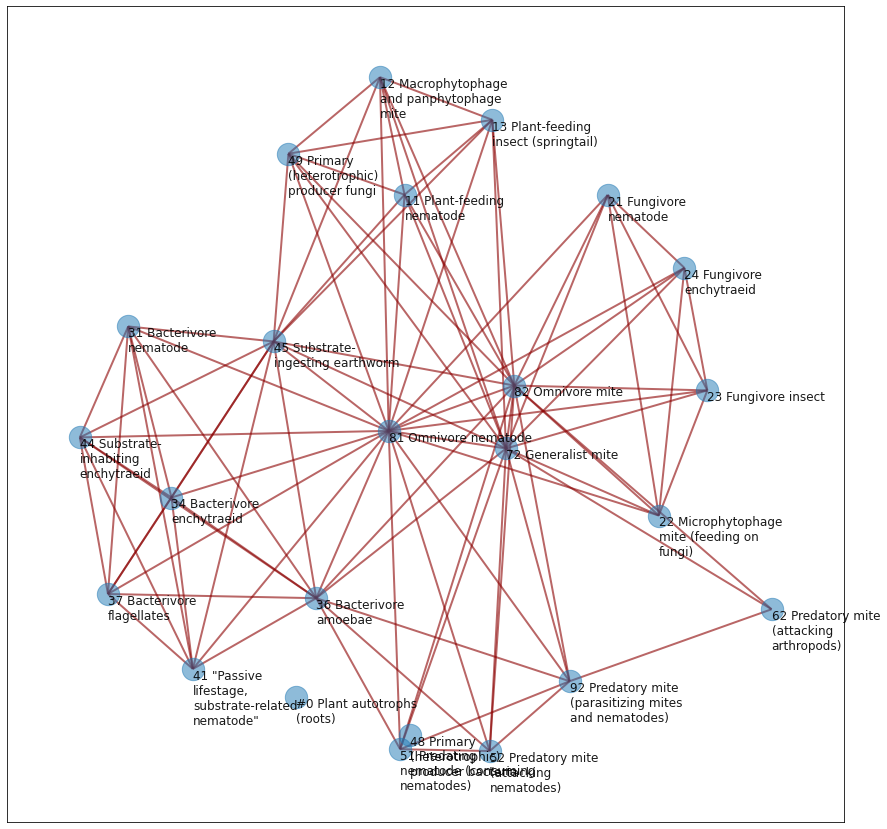

In [3]:
G = nx.read_gpickle("results/Gder_resource.pickle")
trophic_levels = pd.read_pickle('results/trophic_levels.pickle')

fig, ax = plt.subplots(figsize=(15, 15))
draw_network(G, ax)

Continuous feature vectors (embeddings) of the networks' nodes are learned with the node2vec [1] algorithm that maps the nodes to a low-dimensional space of features that maximizes the likelihood of preserving network neighborhoods of nodes.

1 _Grover, Aditya, and Jure Leskovec. "node2vec: Scalable feature learning for networks." Proceedings of the 22nd ACM SIGKDD international conference on Knowledge discovery and data mining. 2016._

#### 5.1.1 Node2Vec

Set the parameters of the node2vec algorithm and fit the model to the soil food web data.

In [4]:
node2vec = Node2Vec(G, dimensions=5, walk_length=15, num_walks=100, workers=1)  
model = node2vec.fit(window=5, min_count=1, seed=42)

Computing transition probabilities:   0%|          | 0/24 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|████████████████████████████████████| 100/100 [00:00<00:00, 767.80it/s]


With the obtained embeddings of nodes it is possible to calculate the distance between points in the vector space. As an example, a search for the most similar node to the one given is performed. 

First, with a node from trophic level 0.

In [5]:
model.wv.most_similar('11 Plant-feeding nematode',  topn=3)

[('49 Primary (heterotrophic) producer fungi', 0.9926649332046509),
 ('12 Macrophytophage and panphytophage mite', 0.97699373960495),
 ('13 Plant-feeding insect (springtail)', 0.9687343835830688)]

Second, with a node from trophic level 3.

In [6]:
model.wv.most_similar('72 Generalist mite', topn=3)

[('82 Omnivore mite', 0.9824984669685364),
 ('62 Predatory mite (attacking arthropods)', 0.9518155455589294),
 ('52 Predatory mite (attacking nematodes)', 0.9397411346435547)]

To obain a matrix with the node embeddings the node vectors are extracted and stored in an array. The vectors' values are normalised and dimensionality reduction is performed with UMAP to obtain the embeddings in 1D and 2D space.

In [7]:
from sklearn.preprocessing import StandardScaler
import umap

node_embeddings = np.array([model.wv.get_vector(node) for node in model.wv.key_to_index])
node_names = [node for node in model.wv.key_to_index]

scaled_array = StandardScaler().fit_transform(node_embeddings)
scaled_df = pd.DataFrame(scaled_array)

# 1D embedding
reducer = umap.UMAP(n_components=1, random_state=123) #n_neighbors=5, min_dist=0.5, metric="euclidean"
node_embeddings_1D = reducer.fit_transform(scaled_df)

# 2D embedding
reducer = umap.UMAP(n_components=2, random_state=123) #n_neighbors=5, min_dist=0.5, metric="euclidean"
node_embeddings_2D = reducer.fit_transform(scaled_df)

The node embeddings can now be projected and visualised in 1D. The node colors are random and represent the trophic levels. Results reveal that certain trophic groups with common resources are closer in space, which is in line with their position in the derived network. The same could be done with the other derived network, which is less suitable for this task as it is much more connected and the graph itself shows which nodes are similar.

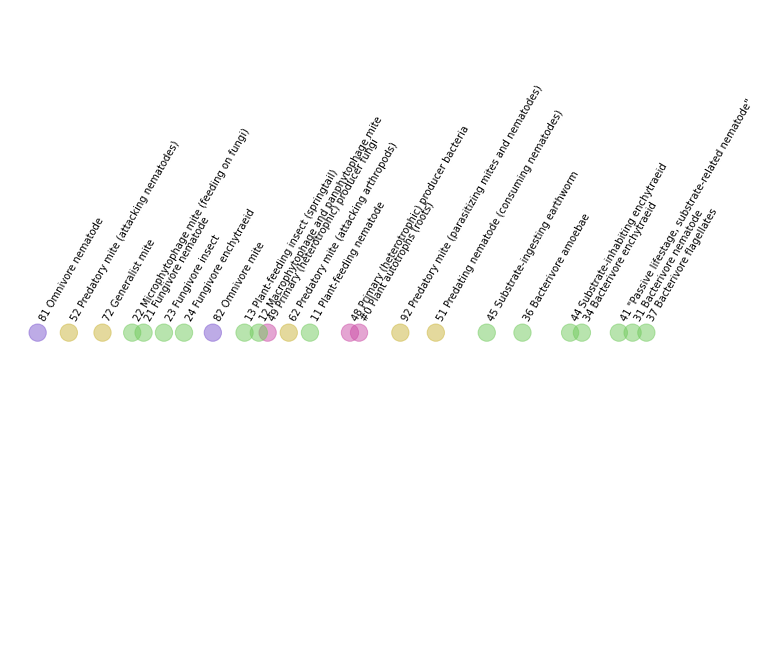

In [8]:
import textwrap
from utils.functions import get_colors

trophic_level_dict = trophic_levels.to_dict()

if len(set(trophic_level_dict.values())) <= 5:
    colors = ["#cb4da6", "#72ca5e", "#7d58cf", "#cbb53c", "#cf4f3e"]
else:
    colors = get_colors(len(set(trophic_level_dict.values())))
node_colors = [colors[trophic_level_dict[node_name]] for node_name in node_names]

x = node_embeddings_1D[:,0]
y = [1] * len(x)

figure = plt.figure(figsize=(12, 12))
_ = plt.scatter(x, y, c=node_colors, marker = "o", s=300, alpha=0.5)
_ = plt.axis('off')

for i, xy in enumerate(zip(x, y)):
    label = '\n'.join(textwrap.wrap(node_names[i], 30, break_long_words=True))
    plt.annotate(node_names[i], (xy[0], xy[1] + 0.002), fontsize=10, rotation=60)
    
plt.savefig('results/figures/1D_embedding.png')

The same can be done with the node embeddings in 2D space and a similar pattern of distances among trophic groups can be observed.

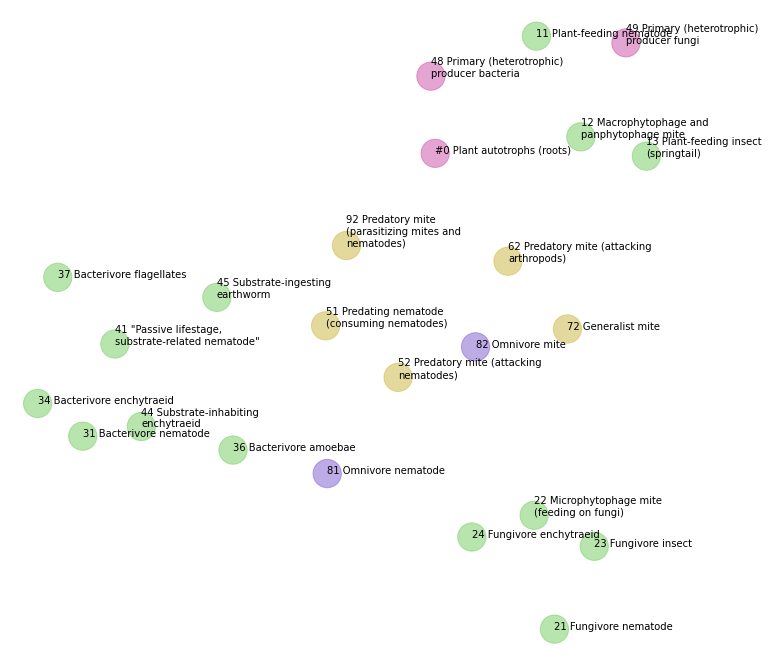

In [9]:
import textwrap
from utils.functions import get_colors

trophic_level_dict = trophic_levels.to_dict()

if len(set(trophic_level_dict.values())) <= 5:
    colors = ["#cb4da6", "#72ca5e", "#7d58cf", "#cbb53c", "#cf4f3e"]
else:
    colors = get_colors(len(set(trophic_level_dict.values())))
node_colors = [colors[trophic_level_dict[node_name]] for node_name in node_names]

x = node_embeddings_2D[:,0]
y = node_embeddings_2D[:,1]

figure = plt.figure(figsize=(12, 12))
_ = plt.scatter(x, y, c=node_colors, s=800, alpha=0.5)
_ = plt.axis('off')

for i, xy in enumerate(zip(x, y)):
    label = '\n'.join(textwrap.wrap(node_names[i], 30, break_long_words=True))
    plt.annotate(label, (xy[0], xy[1]), fontsize=10)